# Use emcee to run MCMC using Lya likelihood from BOSS P1D

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
# temporal
import camb
# our own modules
import simplest_emulator
import linear_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import camb_cosmo
import fit_linP
import recons_cosmo
import compute_likelihood

## Setup Lya likelihood function

In [2]:
# read P1D measurement
basedir='../../p1d_data/data_files/PD2013/'
data=data_PD2013.P1D_PD2013(basedir=basedir,blind_data=True)
zs=data.z
Nz=len(zs)

In [3]:
# load P1D emulator
basedir='/Users/font/CosmoData/test_sim_emulator/test_medium/'
#basedir='../mini_sim_suite/'
p1d_label='mf_p1d'
skewers_label='Ns100_wM0.05'
#emu=simplest_emulator.SimplestEmulator(basedir,p1d_label,skewers_label,max_arxiv_size=10000,verbose=False)
emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,max_arxiv_size=400,verbose=False)

setup interpolator for coefficient 0
[ 0.26472953 -2.30500005 -0.21999954  0.98599613  0.4370181   0.12944179
  1.49569519] test [-0.86698733]
setup interpolator for coefficient 1
[ 0.26472953 -2.30500005 -0.21999954  0.98599613  0.4370181   0.12944179
  1.49569519] test [-0.64956931]
setup interpolator for coefficient 2
[ 0.26472953 -2.30500005 -0.21999954  0.98599613  0.4370181   0.12944179
  1.49569519] test [-0.22486063]
setup interpolator for coefficient 3
[ 0.26472953 -2.30500005 -0.21999954  0.98599613  0.4370181   0.12944179
  1.49569519] test [-0.10114601]
setup interpolator for coefficient 4
[ 0.26472953 -2.30500005 -0.21999954  0.98599613  0.4370181   0.12944179
  1.49569519] test [-0.02172819]


In [4]:
#cProfile.run("emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,max_arxiv_size=400,verbose=False)",sort='cumtime')

In [5]:
# setup nuisance models
mf_model=mean_flux_model.MeanFluxModel()
T_model=thermal_model.ThermalModel()

In [6]:
# specify cosmology
cosmo = camb_cosmo.get_cosmology(mnu=0.15, ns=0.965, omch2=0.12)
# print relevant information about the cosmology object
camb_cosmo.print_info(cosmo)
# compute linear power parameters, around z_star and kp_kms
z_star=3.0
kp_kms=0.009
linP_model=fit_linP.LinearPowerModel(cosmo,z_star=z_star,k_units='kms',kp=kp_kms)
linP_model.get_params()

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 1.6128E-03, T_CMB = 2.7255E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


{'Delta2_star': 0.34359089153174016,
 'alpha_star': -0.21586983258446132,
 'f_star': 0.97514327990258953,
 'g_star': 0.968209492732573,
 'n_star': -2.300572652881717}

In [7]:
# setup fiducial cosmology
cosmo_fid = camb_cosmo.get_cosmology()
# reconstruct cosmology using linear parameter model (at z_star, kp_kms)
rec_cosmo=recons_cosmo.ReconstructedCosmology(linP_model,cosmo_fid)
# compute linear power parameters at each redshift (in Mpc)
linP_Mpc_params=rec_cosmo.get_linP_Mpc_params(zs)

Note: redshifts have been re-sorted (earliest first)


In [8]:
chi2=compute_likelihood.get_chi2(data,cosmo_fid,emu,rec_cosmo,mf_model,T_model,linP_Mpc_params)

In [9]:
chi2

9865.140876589765

In [10]:
#cProfile.run("compute_likelihood.get_chi2(data,cosmo_fid,emu,rec_cosmo,mf_model,T_model,linP_Mpc_params)",sort='cumtime')

### Setup MCMC to call this function

In [11]:
def get_ln_tau_0(x):
    ln_tau_min=-1.1
    ln_tau_max=-0.7
    return ln_tau_min+x*(ln_tau_max-ln_tau_min)

In [12]:
def lnprob(x,data,cosmo_fid,emu,rec_cosmo,linP_Mpc_params):
    # for now priors are top hats in 0 < x < 1
    if max(x) > 1.0: 
        return -np.inf
    if min(x) < 0.0:
        return -np.inf
    ln_tau_0 = get_ln_tau_0(x[0])
    mf_model=mean_flux_model.MeanFluxModel(z_tau=3.0,ln_tau_coeff=[3.18,ln_tau_0])
    T_model=thermal_model.ThermalModel()
    # compute chi2        
    chi2=compute_likelihood.get_chi2(data,cosmo_fid,emu,rec_cosmo,mf_model,T_model,linP_Mpc_params)
    loglike=-0.5*chi2
    # add smooth, weak prior to alleviate NGP in likelihood
    loglike -= (x[0]-0.55)**2/0.01
    #print(x,'log like =',loglike)
    return -0.5*chi2

In [13]:
# for now we'll have only three dimensions (mean flux, temperature, gamma)
ndim=1
# setup initial walkers
nwalkers = 20
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

In [14]:
p0.flatten()

array([ 0.34011989,  0.37864528,  0.22142154,  0.98291785,  0.03245154,
        0.62382046,  0.03475444,  0.62002545,  0.38965638,  0.20215872,
        0.274529  ,  0.30321004,  0.36844938,  0.52563183,  0.79881369,
        0.03217789,  0.16194664,  0.55424512,  0.35682525,  0.62432167])

In [15]:
# test function
lnprob(p0[0],data,cosmo_fid,emu,rec_cosmo,linP_Mpc_params)

-4544.8892197267432

In [16]:
# setup sampler
emu.arxiv.verbose=False
emu.verbose=False
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data,cosmo_fid,emu,rec_cosmo,linP_Mpc_params])

In [17]:
# burn-in phase
for i in range(1):
    pos, prob, state = sampler.run_mcmc(p0, 5)
    print(i,'finished at',pos.flatten(),prob)
    p0=pos

0 finished at [ 0.51694935  0.53377774  0.35614832  0.68672502  0.42475964  0.49868776
  0.35314747  0.49881567  0.46468777  0.20995735  0.274529    0.45630889
  0.55312155  0.52549017  0.79881369  0.2284988   0.25693211  0.52107651
  0.47757827  0.52781294] [-4337.96937745 -4338.54623336 -4505.91727356 -4618.06260634 -4367.09113284
 -4343.75563244 -4512.98480603 -4343.69972102 -4348.56708724 -4974.04579226
 -4726.16815607 -4349.93820669 -4347.46208397 -4338.09104141 -5135.42423281
 -4896.09408329 -4786.8359488  -4337.80063707 -4345.74334452 -4338.40050723]


In [18]:
# reset and run actual chains
sampler.reset()
nsteps=1000
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    if i % 100 == 0:
        print(i,result[0].flatten())

0 [ 0.5174327   0.53893908  0.35614832  0.68672502  0.42475964  0.50075264
  0.4144069   0.49881567  0.47651267  0.20995735  0.274529    0.48369672
  0.53468658  0.52135422  0.79881369  0.2284988   0.25693211  0.52113377
  0.52590267  0.52781294]
100 [ 0.50975083  0.51659587  0.52117869  0.5202649   0.51793418  0.51850742
  0.53129512  0.52170621  0.5299429   0.52080969  0.51997026  0.51829168
  0.51800495  0.51734149  0.52419333  0.51353824  0.53016649  0.53155383
  0.51594574  0.51846379]
200 [ 0.52099424  0.52851501  0.53564684  0.53054196  0.53427754  0.53748589
  0.51409004  0.50991869  0.51960424  0.53788725  0.51840065  0.52294175
  0.512067    0.52407059  0.53165712  0.51737149  0.53946501  0.53665987
  0.52406828  0.51815296]
300 [ 0.51636999  0.51286319  0.52034685  0.51887232  0.52077537  0.51973181
  0.52415085  0.52204835  0.52340038  0.51606387  0.53839425  0.51759931
  0.52151594  0.5221149   0.51471992  0.51687133  0.50346822  0.51551394
  0.51871466  0.52894714]
400 [ 

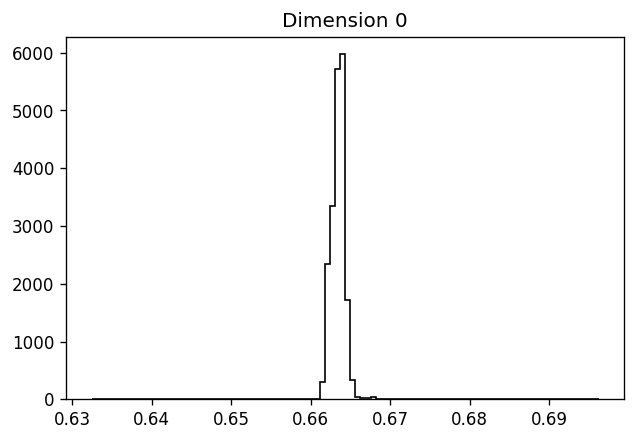

In [19]:
for i in range(ndim):
    plt.figure()
    plt.hist(np.exp(-np.exp(get_ln_tau_0(sampler.flatchain[:,i]))), 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))

In [20]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.792


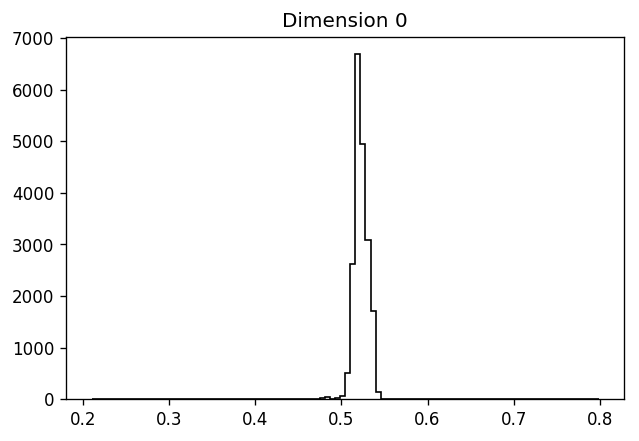

In [21]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))

In [22]:
xs=np.linspace(0.0,1.0,100)

In [23]:
lnps=[lnprob([x],data,cosmo_fid,emu,rec_cosmo,linP_Mpc_params) for x in xs]

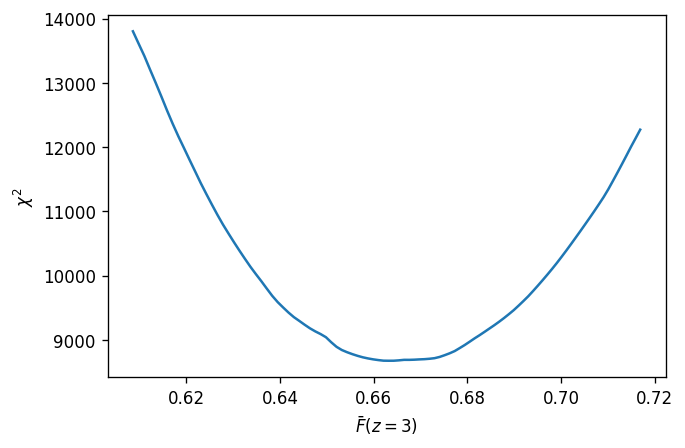

In [24]:
plt.plot(np.exp(-np.exp(get_ln_tau_0(xs))),-2.0*np.array(lnps))
plt.xlabel(r'$\bar F(z=3)$')
plt.ylabel(r'$\chi^2$')